## VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.utils as vutils


from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.stats import norm

In [2]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In the following section we implement the VAE network. 

Our implementation consists of 3 parts:

1.encoder

2.reparameterization

3.decoder

In the encoder part we have implemneted a CNN with two layers of convolutions and two fully connected layers. and our activation function after each convolutional layer is relu. the finall result of this part is 2 vectors (mu. logVar). 

In the reparametrization part we recieve mu and logVar vectors and we compute the latent vector z by the folowing formula: z =  mu + exp(logVar/2) * eps

In the final part which is decoder we reciever latenet vector z and do exactly the opposite operations we had done in the encoding part. 

In [3]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, feature_dim=32*20*20, z_dim=1):
        super(VAE, self).__init__()
        # initialization for the encoder
        self.encoder_conv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encoder_conv2 = nn.Conv2d(16, 32, 5)
        self.encoder_f1 = nn.Linear(feature_dim, z_dim)
        self.encoder_f2 = nn.Linear(feature_dim, z_dim)

        # initialization for the decoder
        self.decoder_f1 = nn.Linear(z_dim, feature_dim)
        self.decoder_conv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decoder_conv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encoder_f1(x)
        logVar = self.encoder_f2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        x = F.relu(self.decoder_f1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))
        return x

    def forward(self, x):

        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

here we bulid our inputs with batch size equal to 128 and num_epochs is the total epoch number and our learning rate is 1e^-3

In [4]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 25

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In this section we train our network .

we choose adam az our optimizer and our loss function consists of two parts one is for BCE and the other part is for KL divergence which we described each of them it in the report

In [ ]:
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

improvement = []
total_loss = []
all_mu = []
all_logVar = []
all_labels = []

for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, label = data
        imgs = imgs.to(device)

        out, mu, logVar = net(imgs)
        if epoch == num_epochs-1:
          all_mu.append(mu.detach().numpy())
          all_logVar.append(logVar.detach().numpy())
          all_labels.append(np.array(label))
          
        if idx == 0 and epoch % 2 == 0:
          improvement.append(out)
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        total_loss.append(loss)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Here we show th improvement of the outputs of the first batch of the training set

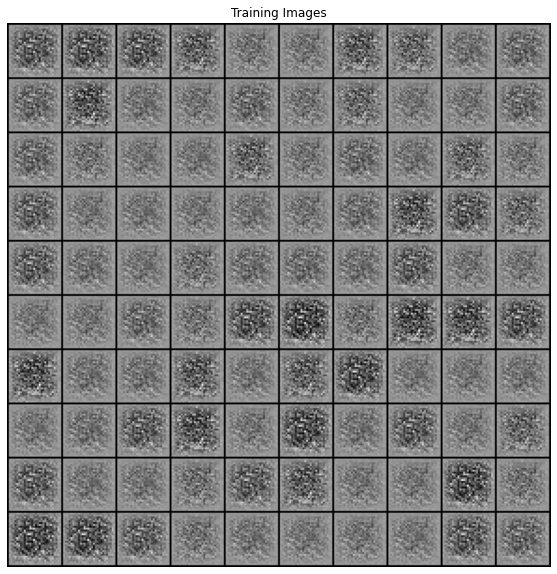

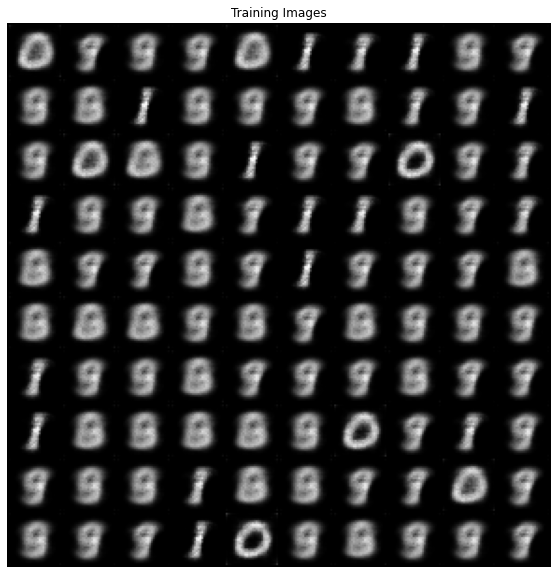

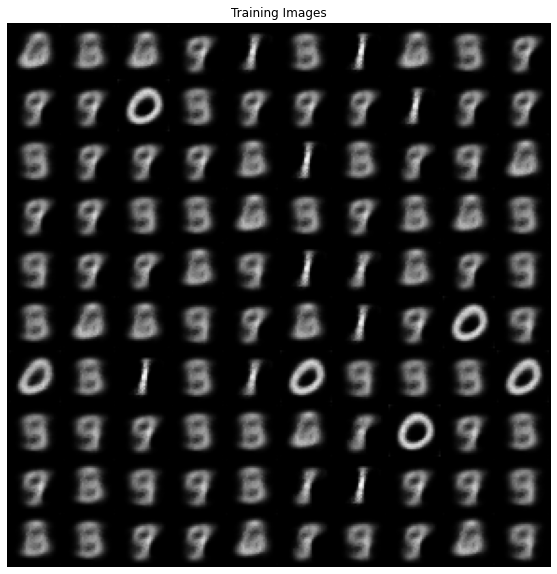

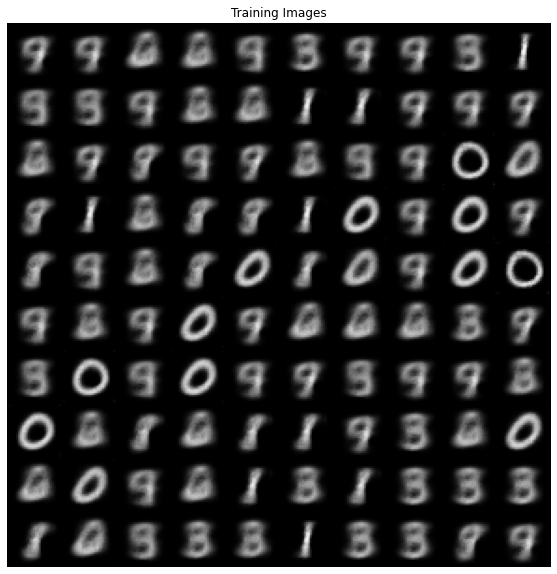

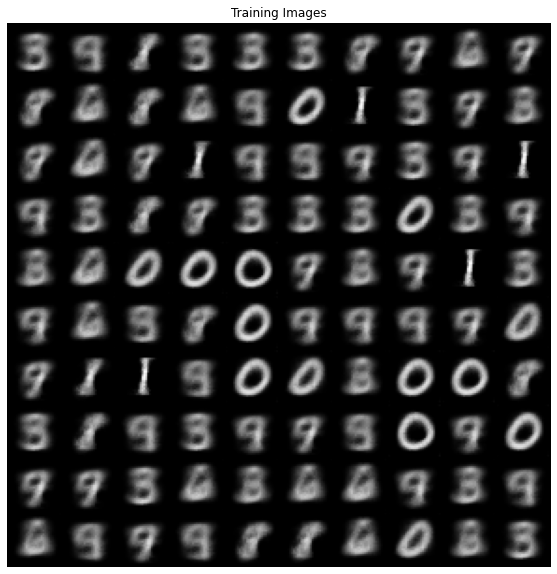

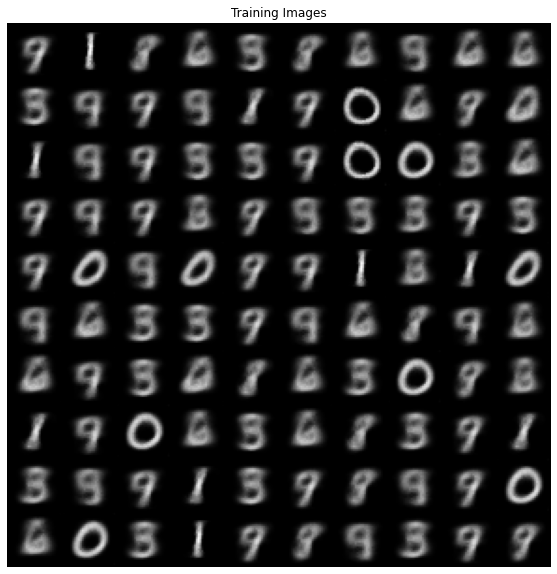

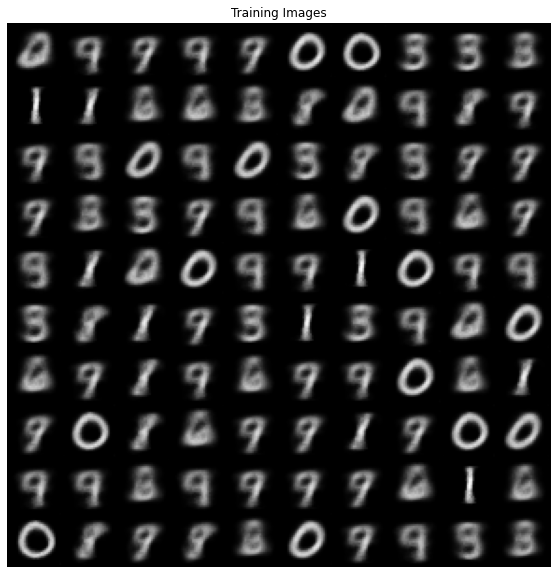

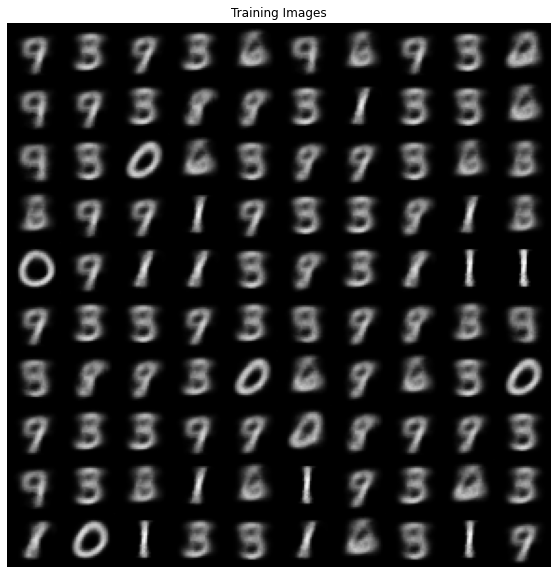

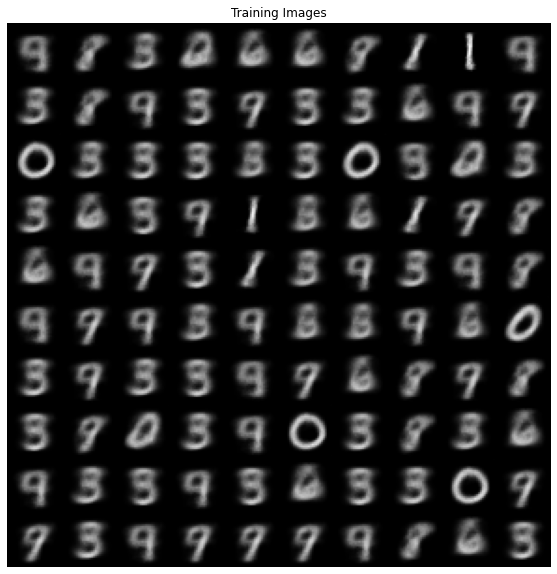

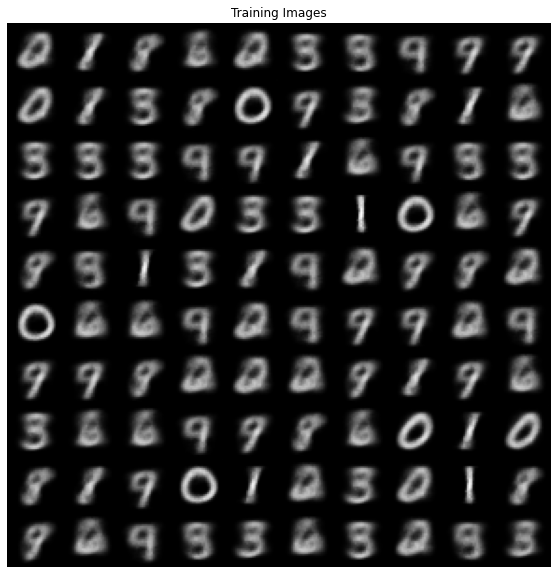

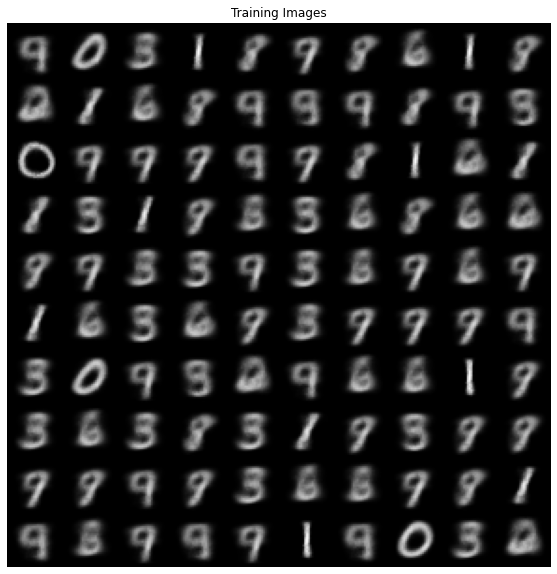

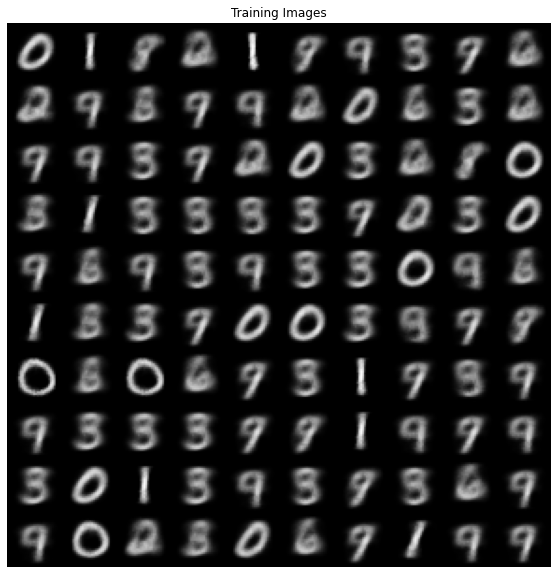

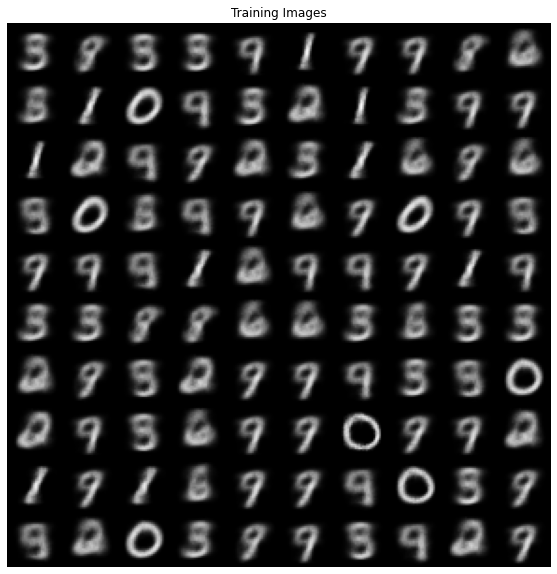

In [ ]:
with torch.no_grad():
    for idx, imgs in enumerate(improvement):
        imgs = imgs[0:100]
        imgs = imgs.to(device)

        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=1, nrow = 10, normalize=True).cpu(),(1,2,0)))


and our loss function is plotted as follow

No handles with labels found to put in legend.


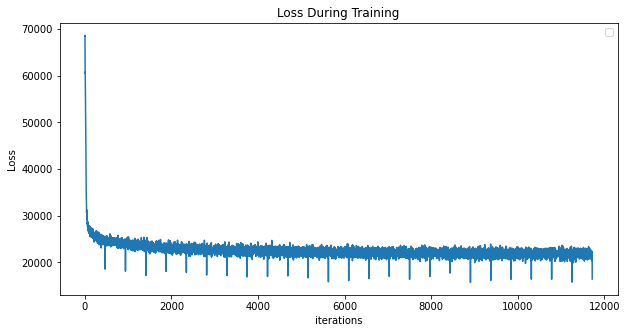

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(total_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
input_imgs = []
output_imgs = []
for idx, data in enumerate(train_loader, 0):
  if idx == 1:
    break
  
  else:    
    imgs, label = data
    input_imgs.append(imgs)
    imgs = imgs.to(device)
    c = one_hot(label, 10)
    out, mu, logVar = net(imgs)
    output_imgs.append(out)

In order to see how good our network works, we have plotted a 10*10 grid of original images and their following results by the network.

we have kept some images in the last epoch and also we have kept their results in another array

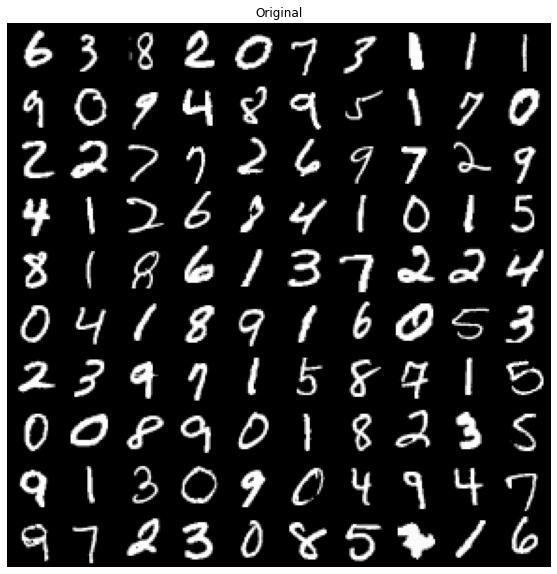

In [ ]:
with torch.no_grad():
  for imgs in input_imgs:
      imgs = imgs[0:100]
      imgs = imgs.to(device)

      plt.figure(figsize=(10,10))
      plt.axis("off")
      plt.title("Original")
      plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=1, nrow = 10, normalize=True).cpu(),(1,2,0)))


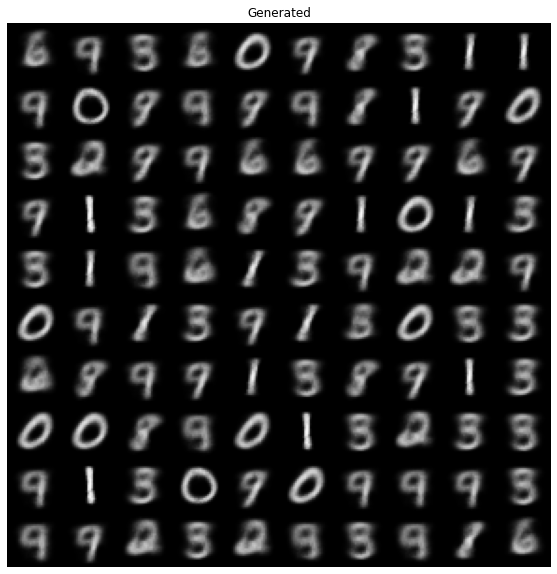

In [ ]:
with torch.no_grad():
  for imgs in output_imgs:
      imgs = imgs[0:100]
      imgs = imgs.to(device)

      plt.figure(figsize=(10,10))
      plt.axis("off")
      plt.title("Generated")
      plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=1, nrow = 10, normalize=True).cpu(),(1,2,0)))


In the following part we have plotted the scatter plot of the achieved variables of the latent space. 

we have kept these two vectors (mu, logVar) in the training part in the last epoch and here we simply plot them using scatter 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

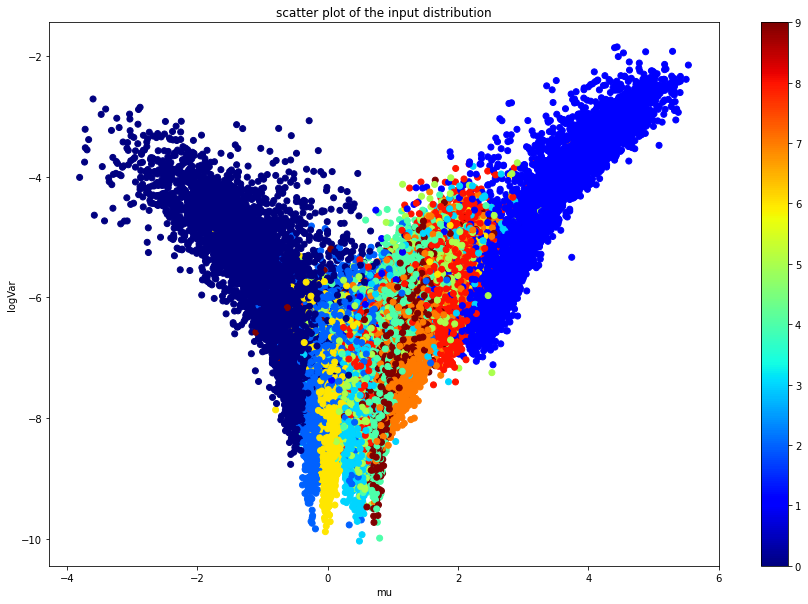

In [ ]:
all_mu = np.array(all_mu)
all_logVar = np.array(all_logVar)
all_mu = all_mu.flatten()
all_logVar = all_logVar.flatten()

all_labels = np.array(all_labels)
all_labels = all_labels.flatten()

plt.figure(figsize=(15, 10))
for i in range(len(all_mu)):
  plt.xlabel('mu')
  plt.ylabel('logVar')
  plt.title('scatter plot of the input distribution')
  plt.scatter(all_mu[i], all_logVar[i], c=all_labels[i], cmap=plt.cm.jet)
plt.colorbar()
plt.show()  

In this section we are plotting a sample grid of the privous part's distribution. 

we implement it by getting some random values named grid_x and grid_y which are in the specific range and then we give this two vectors to networsk's reparametrization and then we give the output to the decoder and then we plot the results

In [ ]:
all_mu_min, all_mu_max = find_min(all_mu)
all_logVar_min, all_logVar_max = find_min(all_logVar)

In [ ]:
all_logVar_min, all_logVar_max

(-10.03517, -1.851848)

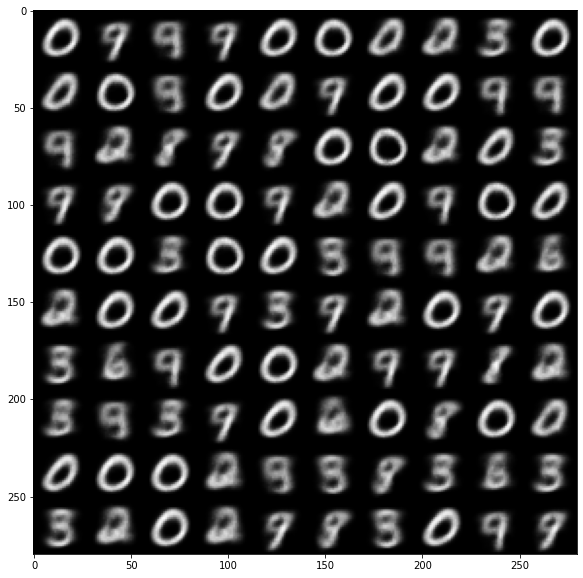

In [ ]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-0.1, 0, n)
grid_y = np.linspace(-0.1, 0, n)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):  
        z_sample = np.array([[xi, yi]])
        z_sample = torch.from_numpy(z_sample)
        z = net.reparameterize(z_sample[:, 0], z_sample[:, 1])
        
        z = z.float()        
        x_decoded = net.decoder(z)
        
        with torch.no_grad():
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap = 'gray')
plt.show()  


 ## Conditional VAE

In this section we implement CVAE. This part is similar to the previous part with some little differences. 

Here in our encoder part we have concatenated an input vector c which is the one hot representation of the class labels to the flattend image vector (before we apply the fully connected layers) and as a result we change our input dimension of the Linnear function. 

The reparametrization part is the same.

In the decoder part we have also concatenated c vector to the latent vector, as a result our input dimension in the Linear function (decoder_f1) has changed. 

In [45]:
class CVAE(nn.Module):
    def __init__(self, imgChannels=1, feature_dim=32*20*20, class_size=10, z_dim=1):
        super(CVAE, self).__init__()
        # initialization for the encoder
        self.encoder_conv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encoder_conv2 = nn.Conv2d(16, 32, 5)
        self.encoder_f1 = nn.Linear(feature_dim+class_size, z_dim)
        self.encoder_f2 = nn.Linear(feature_dim+class_size, z_dim)

        # initialization for the decoder
        self.decoder_f1 = nn.Linear(z_dim+class_size, feature_dim)
        self.decoder_conv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decoder_conv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x, c): # Q(z|x, c)

        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = x.view(-1, 32*20*20)
        x = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        mu = self.encoder_f1(x)
        logVar = self.encoder_f2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return mu + std * eps

    def decoder(self, z, c): # P(x|z, c)

        z = torch.cat([z, c], 1) # (bs, z_dim+class_size)
        x = F.relu(self.decoder_f1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))
        return x

    def forward(self, x, c):

        mu, logVar = self.encoder(x, c)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z, c)
        return out, mu, logVar


The following code gives us a one hot representation of the class labels 

In [7]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

In [46]:
cvae = CVAE().to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)

improvement = []
total_loss = []
all_mu = []
all_logVar = []
all_labels = []

for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, label = data
        imgs = imgs.to(device)
        c = one_hot(label, 10)
        out, mu, logVar = cvae(imgs, c)
        if epoch == num_epochs-1:
          all_mu.append(mu.detach().numpy())
          all_logVar.append(logVar.detach().numpy())
          all_labels.append(np.array(label))
          
        if idx == 0 and epoch % 2 == 0:
          improvement.append(out)
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        total_loss.append(loss)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 15191.837890625
Epoch 1: Loss 14458.3759765625
Epoch 2: Loss 14869.91015625
Epoch 3: Loss 14107.681640625
Epoch 4: Loss 14704.7314453125
Epoch 5: Loss 14209.6376953125
Epoch 6: Loss 15009.494140625
Epoch 7: Loss 14101.236328125
Epoch 8: Loss 14299.8515625
Epoch 9: Loss 13720.982421875
Epoch 10: Loss 14291.7099609375
Epoch 11: Loss 14213.0439453125
Epoch 12: Loss 14166.087890625
Epoch 13: Loss 14223.6611328125
Epoch 14: Loss 13871.8525390625
Epoch 15: Loss 14930.8525390625
Epoch 16: Loss 13801.455078125
Epoch 17: Loss 14479.8388671875
Epoch 18: Loss 13448.916015625
Epoch 19: Loss 14100.9296875
Epoch 20: Loss 13871.125
Epoch 21: Loss 13995.90625
Epoch 22: Loss 13711.099609375
Epoch 23: Loss 13477.9794921875
Epoch 24: Loss 13770.310546875


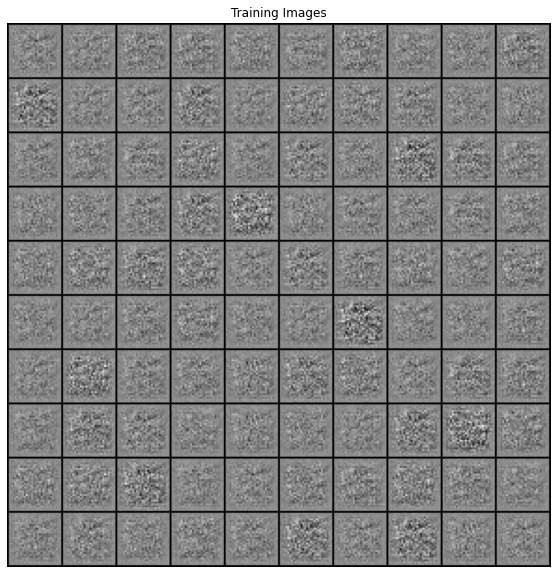

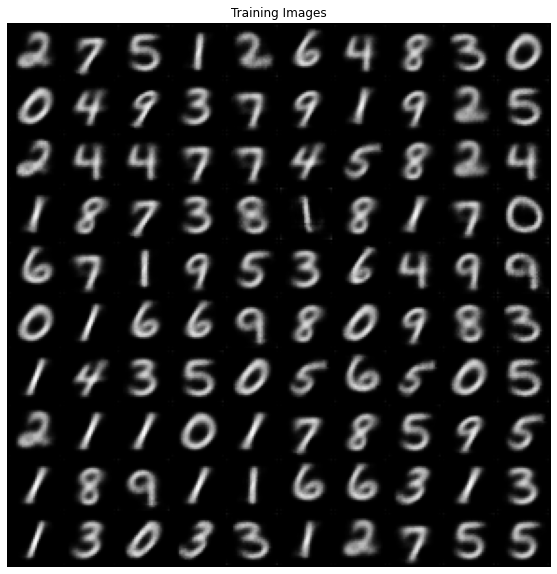

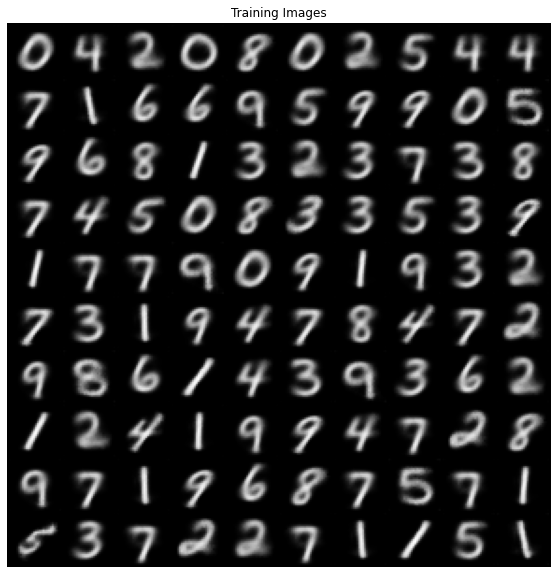

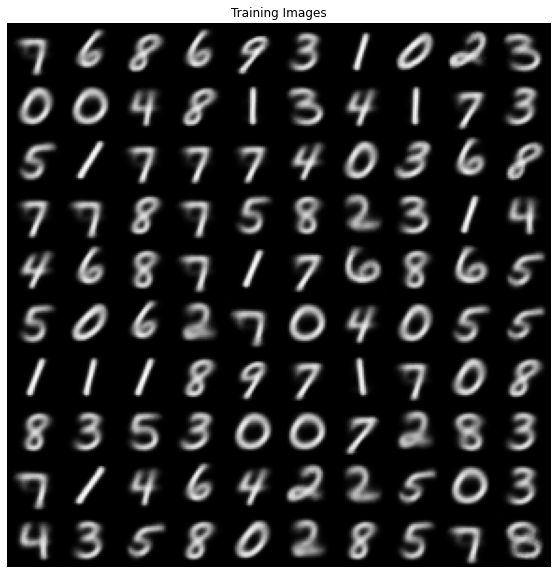

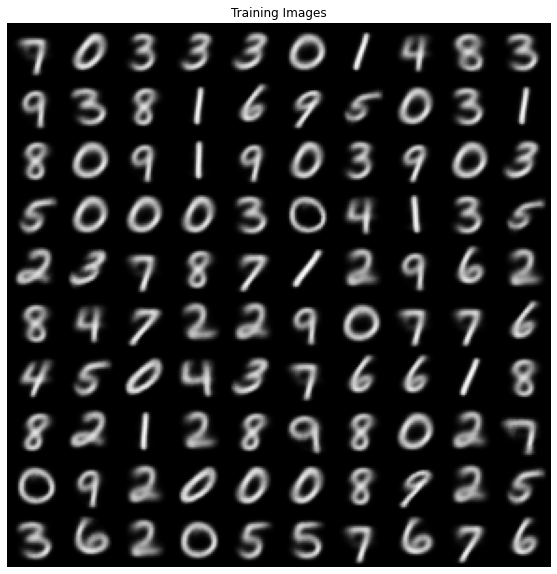

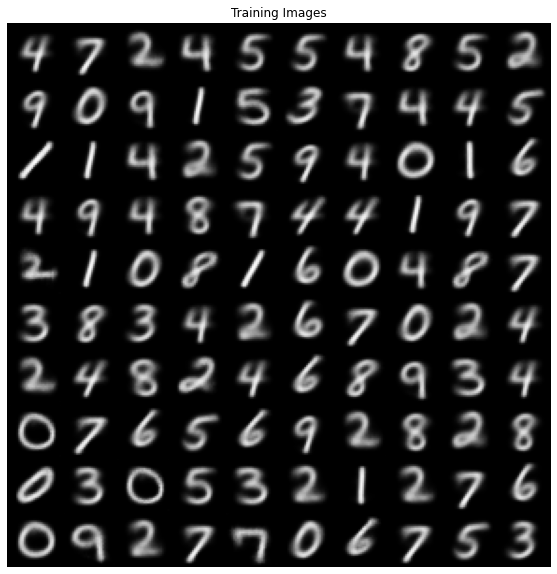

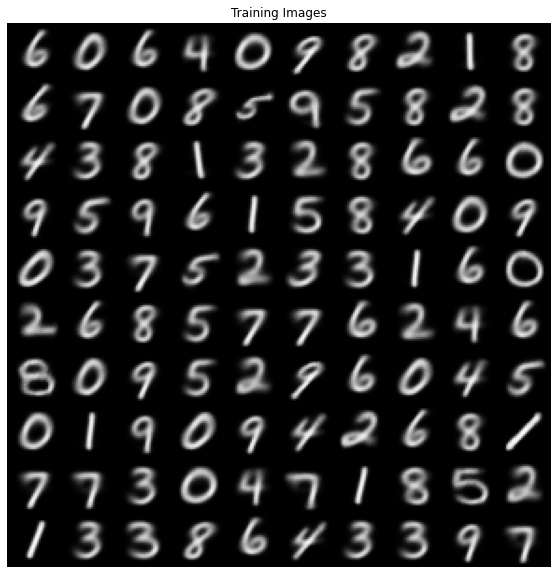

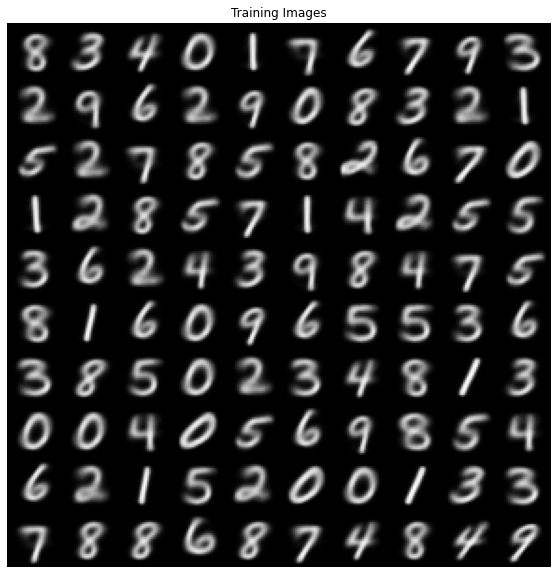

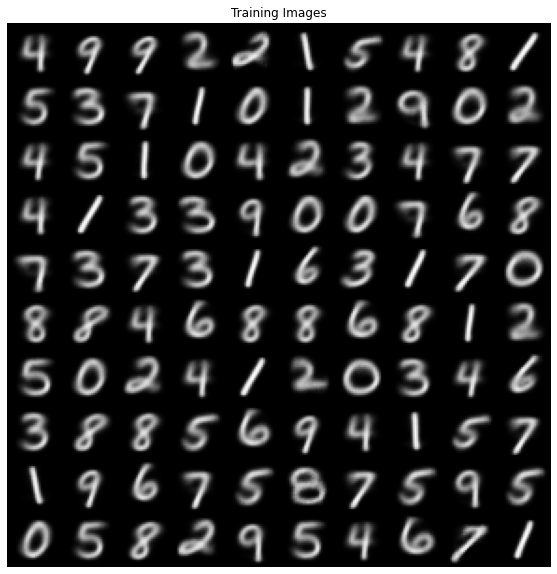

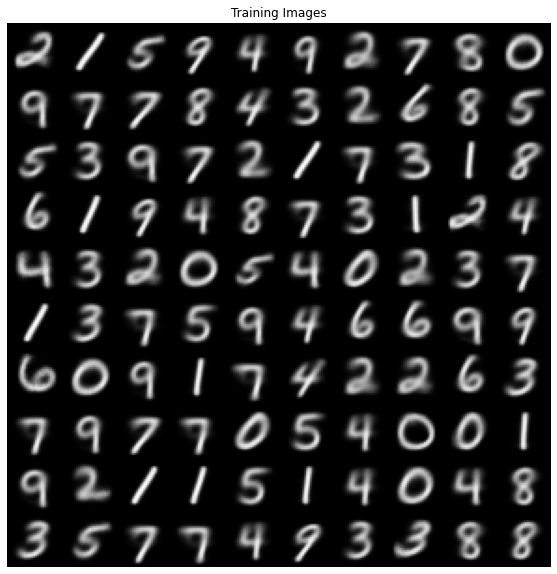

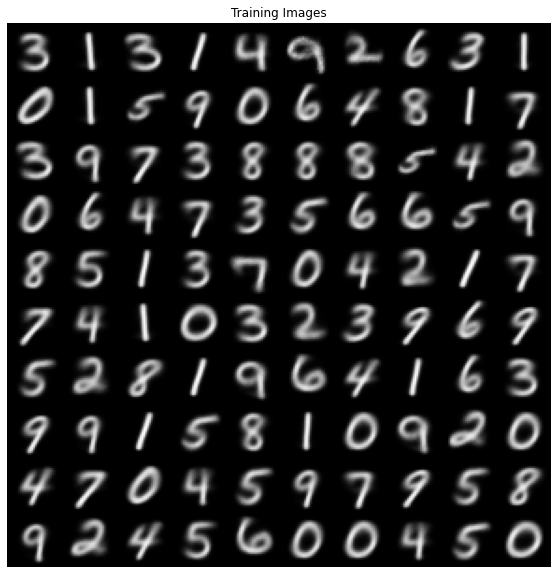

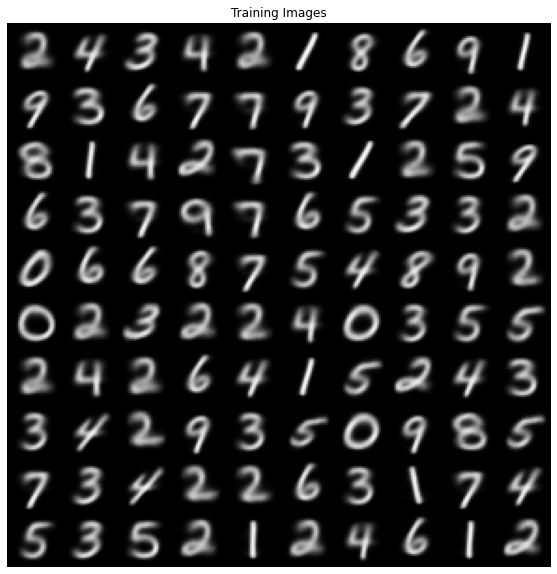

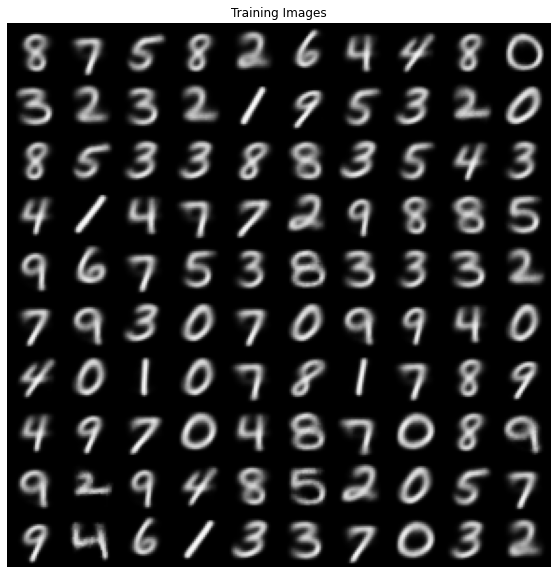

In [ ]:
with torch.no_grad():
    for idx, imgs in enumerate(improvement):
        imgs = imgs[0:100]
        imgs = imgs.to(device)

        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=1, nrow = 10, normalize=True).cpu(),(1,2,0)))


No handles with labels found to put in legend.


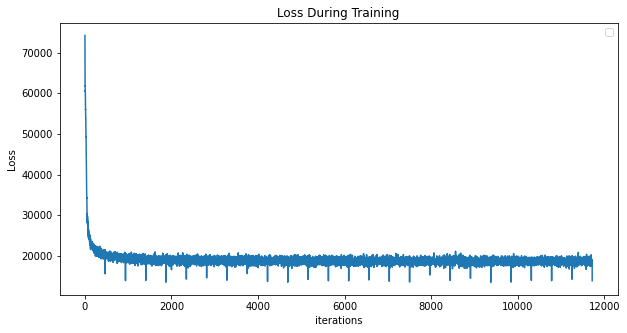

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(total_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
input_imgs = []
output_imgs = []
for idx, data in enumerate(train_loader, 0):
  if idx == 1:
    break
  
  else:    
    imgs, label = data
    input_imgs.append(imgs)
    imgs = imgs.to(device)
    c = one_hot(label, 10)
    out, mu, logVar = cvae(imgs, c)
    output_imgs.append(out)

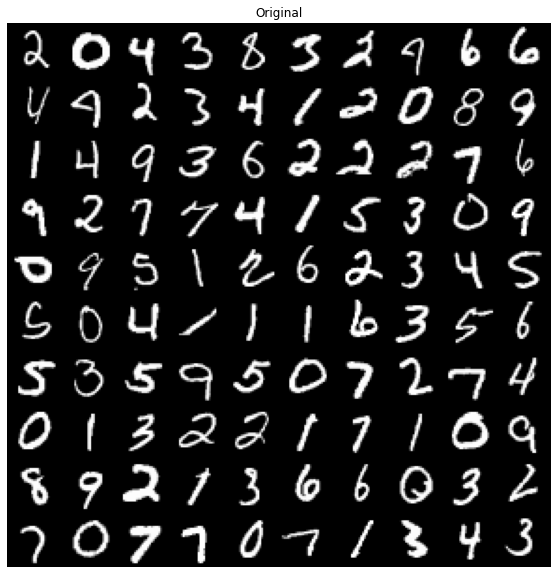

In [ ]:
with torch.no_grad():
  for imgs in input_imgs:
      imgs = imgs[0:100]
      imgs = imgs.to(device)

      plt.figure(figsize=(10,10))
      plt.axis("off")
      plt.title("Original")
      plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=1, nrow = 10, normalize=True).cpu(),(1,2,0)))


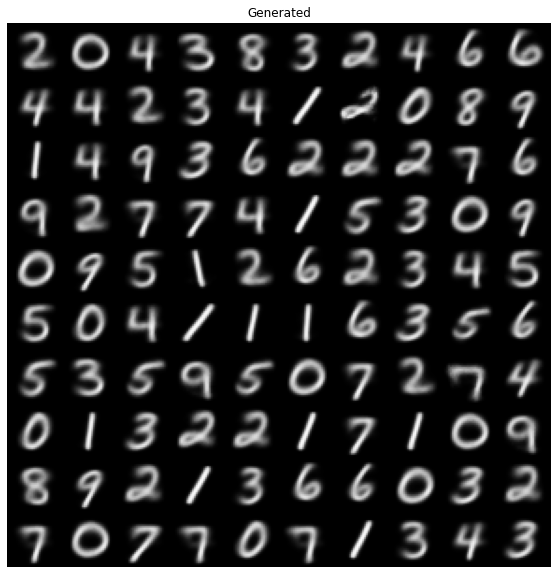

In [ ]:
with torch.no_grad():
  for imgs in output_imgs:
      imgs = imgs[0:100]
      imgs = imgs.to(device)

      plt.figure(figsize=(10,10))
      plt.axis("off")
      plt.title("Generated")
      plt.imshow(np.transpose(vutils.make_grid(imgs.to(device), padding=1, nrow = 10, normalize=True).cpu(),(1,2,0)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

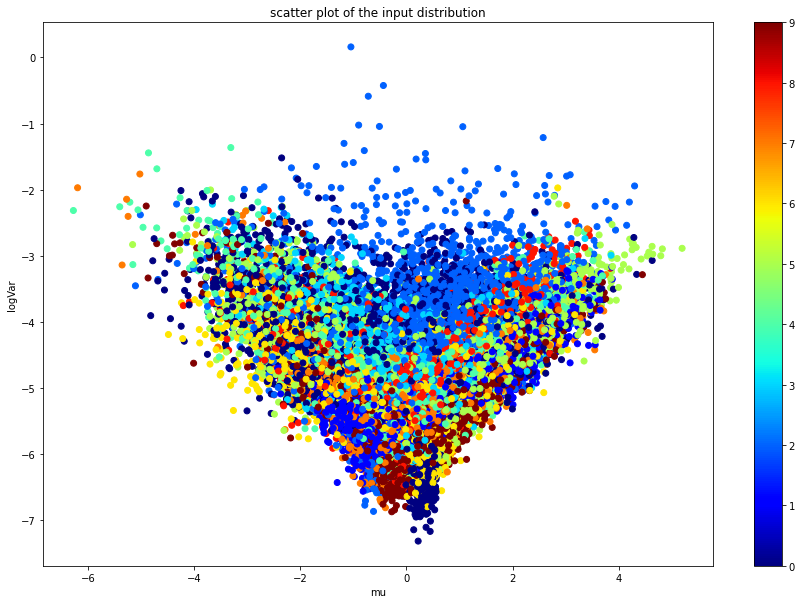

In [ ]:
all_mu = np.array(all_mu)
all_logVar = np.array(all_logVar)
all_mu = all_mu.flatten()
all_logVar = all_logVar.flatten()

all_labels = np.array(all_labels)
all_labels = all_labels.flatten()

plt.figure(figsize=(15, 10))
for i in range(len(all_mu)):
  plt.xlabel('mu')
  plt.ylabel('logVar')
  plt.title('scatter plot of the input distribution')
  plt.scatter(all_mu[i], all_logVar[i], c=all_labels[i], cmap=plt.cm.jet)
plt.colorbar()
plt.show()  

In [ ]:
def find_min(arr):
  minimum = 1000000
  maximum = -100000
  for a in arr:
    temp_min = a.min()
    temp_max = a.max()
    if temp_min < minimum:
      minimum = temp_min
    if temp_max > maximum:  
      maximum = temp_max
  return minimum, maximum     

In [ ]:
all_mu_min, all_mu_max = find_min(all_mu)
all_logVar_min, all_logVar_max = find_min(all_logVar)

In [ ]:
all_logVar_min, all_logVar_max

(-7.321189, 0.16031063)

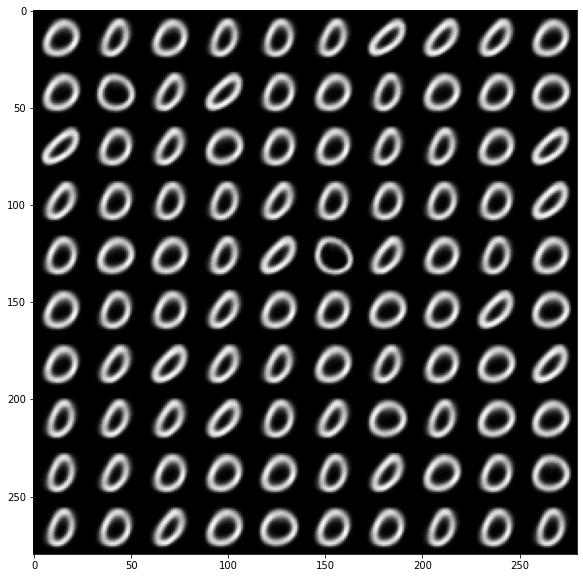

In [47]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-0.1, 0, n)
grid_y = np.linspace(-0.1, 0, n)

c = torch.zeros(1, 10)
c[0, 0] = 1

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):  
        z_sample = np.array([[xi, yi]])
        z_sample = torch.from_numpy(z_sample)
        z = cvae.reparameterize(z_sample[:, 0], z_sample[:, 1])
        
        z = z.float()        
        z = z.view([1, 1])
        x_decoded = cvae.decoder(z, c)
        
        with torch.no_grad():
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap = 'gray')
plt.show()  
